# COMP9318 Project
## Exploratory Data Analysis

In [14]:
import helper as h
import submission as s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas2arff
from IPython.display import display


pd.set_option('display.max_rows', 500)

Read in word data:

In [2]:
data_loc = 'asset/training_data.txt'
data = h.read_data(data_loc)
words = s.get_words(data)

In [3]:
words.columns

Index(['word', 'pronunciation', 'pn_list', 'destressed_pn_list',
       'primary_stress_map', 'primary_stress_index', 'secondary_stress_map',
       'vowel_map', 'consonant_map', 'vector_map', 'vowel_count',
       'consonant_count', 'type_tag', '1st_letter_idx', 'phoneme_length',
       'stressed_vowel', 'ngrams', 'ngram_counts'],
      dtype='object')

### Facts

Most common stressed vowel in descending order. Compare against total count of particular vowel, can then take proability that vowel will be stressed

In [4]:
# Get count where particular vowel is the stress vowel and count where vowel is in existance
stressed_vowel_count = words.groupby('stressed_vowel')['word'].count().sort_values(ascending=False)
total_vowel_count = words[list(h.vowels)].sum()

# Join the two frames
vowel_counts = pd.concat((stressed_vowel_count,total_vowel_count), axis=1, join='inner')
vowel_counts.columns = ['stressed_vowel_count','total_vowel_count']
vowel_counts['vowel_count_prob'] = vowel_counts.stressed_vowel_count/vowel_counts.total_vowel_count
vowel_counts.sort_values(['vowel_count_prob'],ascending=False)

KeyError: "['AA' 'AE' 'AH' 'AO' 'AW' 'AY' 'EH' 'ER' 'EY' 'IH' 'IY' 'OW' 'OY' 'UH' 'UW'] not in index"

Find patterns in training data, build list of all possible consecutive sequences

In [ ]:
def get_ngrams(pronunciation_list,length):
    return tuple(zip(*(pronunciation_list[i:] for i in range(length))))

def get_sequences(phoneme_series):
    ngrams = {}
    max_length = max(phoneme_series.str.len())
    for i in range(2, max_length + 1):
        for pn_list in phoneme_series:
            # Next iteration if pn_list is shorter then the sequence length be built
            if len(pn_list) < i:
                continue
            word_ngrams = get_ngrams(pn_list,i)
            for ngram in word_ngrams:
                ngrams[ngram] = ngrams.get(ngram,0) + 1
    return ngrams

def in_list(pn_list,ngram):
    if pn_list in ngram:
        return 1
    return 0

def is_primary(ngram):
    for phoneme in ngram:
        if '1' in phoneme:
            return True
    return False

def has_ngram(ngram,ngram_set):
    # Do not check sequences of length 2 or the final as they will obviously be in the set
    for i in range(2,len(ngram)):
        subsequence = ngram[0:i]
        if subsequence in ngram_set :
            return True
    return False




destressed_ngrams = get_sequences(words.destressed_pn_list)
destressed_ngrams_df = pd.DataFrame(list(destressed_ngrams.items()),columns=['destressed_ngram','destressed_ngram_count'])
destressed_ngrams_df = destressed_ngrams_df.set_index('destressed_ngram',drop=False)

# Generate Dataframe with all ngram possibiities and get counts, flag if primary stress in sequence
ngrams = get_sequences(words.pn_list)
ngram_df = pd.DataFrame(list(ngrams.items()),columns=['ngram','ngram_count'])

# Return True is sequence has primary stress in it
ngram_df['Is_Primary'] = ngram_df.ngram.apply(is_primary)
ngram_df['destressed_ngram'] = ngram_df.ngram.apply(h.filter_stress)
ngram_df.destressed_ngram = ngram_df.destressed_ngram.apply(h.as_tuple)
ngram_df = ngram_df.query('Is_Primary == True').set_index('destressed_ngram')

# Join
ngram_priors = ngram_df.join(destressed_ngrams_df)

# Get probability that sequence if exists will be stressed
ngram_priors['ngram_stress_probability'] = ngram_priors.ngram_count/ngram_priors.destressed_ngram_count
ngram_priors['ngram_length'] = ngram_priors.ngram.str.len() 

In [ ]:
# Return true if ngram in family
def in_family(family,ngram):
    return family == ngram[0:len(family)]

# Add series to data frame which include the smallest ngram within a larger ngram
def collapse_ngrams(ngram_df,column):
    ngram_df.sort_index(inplace=True)
    ngrams = ngram_df[column].values.tolist()
    ngram_families = []
    current_family = ngrams[0]
    for ngram in ngrams:
        if not in_family(current_family,ngram):
            current_family = ngram
        ngram_families.append(current_family)
    ngram_df['ngram_family'] = pd.Series(ngram_families).values
    return ngram_df

collapse_ngrams(ngram_df,'ngram')

In [ ]:
valid_seqs = ngram_priors.query('Sequence_Stress_Probability  < 1 & Destressed_Sequence_Count > 5')
valid_seqs.sort_values(by=['Sequence_Stress_Probability','Destressed_Sequence_Count'],ascending=False)
#sequences_df.query('Sequence_Stress_Probability > 0.5  & Destressed_Sequence_Count > 5').sort_values(by='Destressed_Sequence',ascending=False)
ngram_priors.query('Sequence_Stress_Probability > 0.5  & Sequence_Length < 3')

# Doorknob
ngram_priors.loc[[('UW','R'),('AA','B')]]

# Rabon
#RABON:R AA0 B AO1 N
ngram_priors.loc[[('AA','B'),('AO','N')]]

#ABILA:AA0 B IY1 L AH0
ngram_priors.loc[[('AA','B'),('IY','L')]]


Only show sequences that appear in atleast 1% of words in training data. Compare sequence with stresses included.

In [ ]:
sequences_df.sort_values(by='Sequence',ascending=True)

Remove longer super sequences that can be described by a existing sub sequence

In [ ]:
def has_subsequence(sequence,sequence_set):
    # Do not check sequences of length 2 or the final as they will obviously be in the set
    for i in range(2,len(sequence)):
        subsequence = sequence[0:i]
        if subsequence in sequence_set :
            return True
    return False

sequences_df['Has_Subsequence'] = sequences_df.Sequence.apply(has_subsequence,args=(set(sequences_df.Sequence),))
sequences_df

### Plots

In [20]:
%matplotlib inline


def scatter_plot(x,y):
    fig = plt.figure()
    ax  = fig.add_subplot(1,1,1)
    ax.scatter(x,y)
    plt.title("{} vs {}".format(y.name,x.name))
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.show()
    return

def histogram(data):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.hist(data,bins='auto')
    plt.title('{} Distribution'.format(data.name))
    plt.xlabel('{}'.format(data.name))
    #plt.xlim(0,15)
    #plt.ylim(0,5000)
    plt.show()
    return    

CC


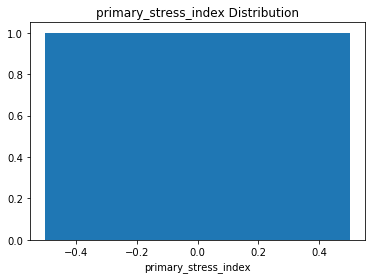

DT


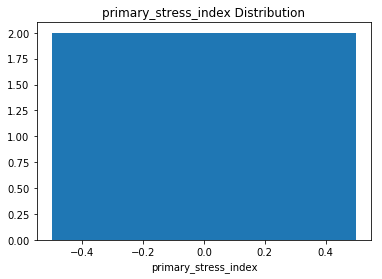

FW


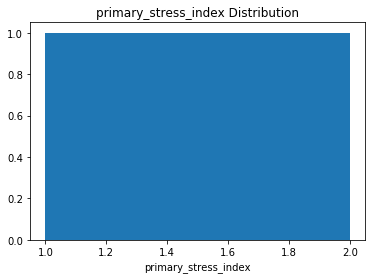

IN


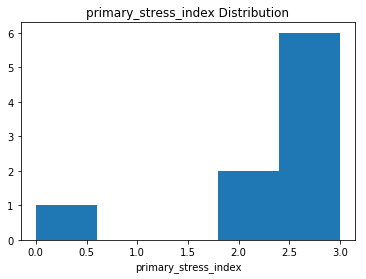

JJ


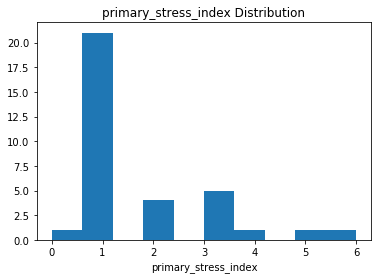

JJR


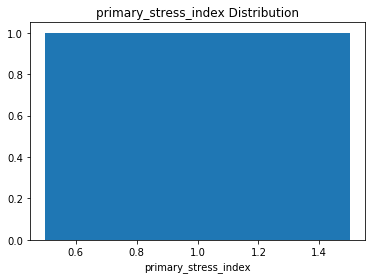

NN


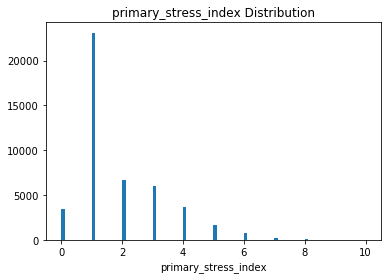

NNP


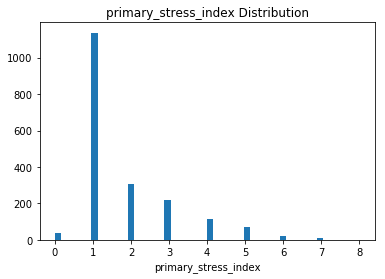

NNS


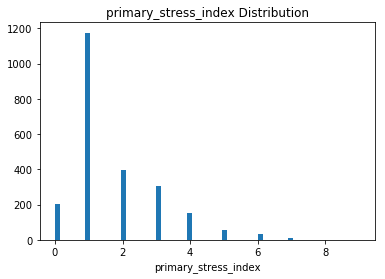

RB


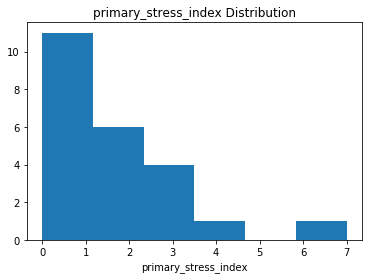

VB


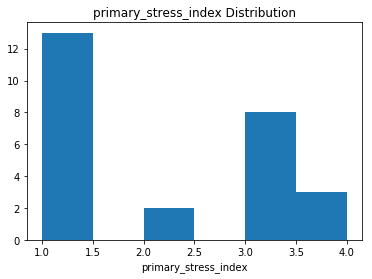

WDT


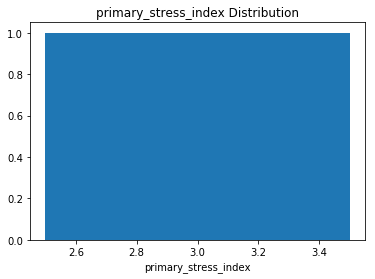

WP


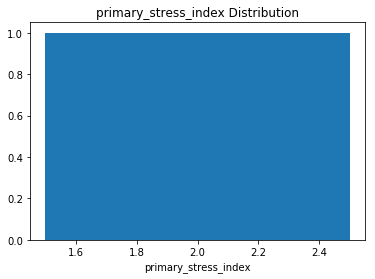

In [21]:
for type_tag in sorted(words.type_tag.unique()):
    df = words[words['type_tag'] == type_tag]
    print(type_tag)
    histogram(df['primary_stress_index'])

In [15]:
words[['primary_stress_index','word','phoneme_length','type_tag']].groupby(by='type_tag').describe()

phoneme_length  primary_stress_index
type_tag                                            
CC       count        1.000000              1.000000
         mean         3.000000              0.000000
         std               NaN                   NaN
         min          3.000000              0.000000
         25%          3.000000              0.000000
         50%          3.000000              0.000000
         75%          3.000000              0.000000
         max          3.000000              0.000000
DT       count        2.000000              2.000000
         mean         3.500000              0.000000
         std          0.707107              0.000000
         min          3.000000              0.000000
         25%          3.250000              0.000000
         50%          3.500000              0.000000
         75%          3.750000              0.000000
         max          4.000000              0.000000
FW       count        2.000000              2.000000
         mean         6.000000              1.500000
         std          2.828427              0.707107
         min          4.000000              1.000000
         25%          5.000000              1.250000
         50%          6.000000              1.500000
         75%          7.000000              1.750000
         max          8.000000              2.000000
IN       count        9.000000              9.000000
         mean         4.555556              2.444444
         std          0.881917              1.013794
         min          3.000000              0.000000
         25%          4.000000              2.000000
         50%          5.000000              3.000000
         75%          5.000000              3.000000
         max          6.000000              3.000000
JJ       count       34.000000             34.000000
         mean         6.058824              1.735294
         std          1.937527              1.309842
         min          3.000000              0.000000
         25%          5.000000              1.000000
         50%          5.500000              1.000000
         75%          7.750000              2.000000
         max         10.000000              6.000000
JJR      count        1.000000              1.000000
         mean         3.000000              1.000000
         std               NaN                   NaN
         min          3.000000              1.000000
         25%          3.000000              1.000000
         50%          3.000000              1.000000
         75%          3.000000              1.000000
         max          3.000000              1.000000
NN       count    45656.000000          45656.000000
         mean         6.463860              1.848454
         std          1.702237              1.418300
         min          2.000000              0.000000
         25%          5.000000              1.000000
         50%          6.000000              1.000000
         75%          8.000000              3.000000
         max         14.000000             10.000000
NNP      count     1912.000000           1912.000000
         mean         6.174686              1.780858
         std          1.597299              1.274715
         min          3.000000              0.000000
         25%          5.000000              1.000000
         50%          6.000000              1.000000
         75%          7.000000              2.000000
         max         13.000000              8.000000
NNS      count     2332.000000           2332.000000
         mean         7.291595              1.740995
         std          1.825003              1.327781
         min          3.000000              0.000000
         25%          6.000000              1.000000
         50%          7.000000              1.000000
         75%          9.000000              2.000000
         max         13.000000              9.000000
RB       count       23.000000             23.000000
         mean         5.086957           

In [ ]:
histogram(sequence_df[sequence_df.Sequence_Count > 0].Sequence_Count)